# Question 1

# Q1.1

lot_type refers to types of lots available at point of data retrieval. Where C refers to car lot, H for heavy vehicles and Y for motorcycles

# 1.2
First, we make an API call for the data from a single specified date & time using the sample code

In [2]:
import requests
import json
import pandas as pd

In [3]:
# Change these values for different dates
year = "2022"
month = "4"
day = "12"
hour = "12"
minute = "30"
second = "0"

site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
print(site)
response_API = requests.get(site)
data = response_API.text
data = json.loads(data)
timestamp = data["items"][0]["timestamp"]
print(timestamp)

data = data["items"][0]["carpark_data"]
with open("EE4211data.json", 'w') as fp:
    json.dump(data, fp)
df = pd.read_json("EE4211data.json")
for heading in ("total_lots","lot_type","lots_available"):
    df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
df = df.drop(["carpark_info"], axis=1)
df

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2022-04-12T12%3A30%3A00


KeyError: 'items'

Next, we make a call for the next second.

In [ ]:
second = '1'
site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
print(site)
response_API = requests.get(site)
data = response_API.text
data = json.loads(data)
timestamp = data["items"][0]["timestamp"]
print(timestamp)

We notice that the updated time has not changed. Therefore, in the following step, we try to figure out the frequency
at which the data values are updated by repeatedly making the call for an interval of 90 seconds. 

In [ ]:
def get_timestamp(min_str, sec_str):
    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{min_str.zfill(2)}%3A{sec_str.zfill(2)}'
    print(site)
    response_API = requests.get(site)
    data = response_API.text
    data = json.loads(data)
    timestamp = data["items"][0]["timestamp"]
    print(timestamp)
minute = 30
second = 0
for i in range(0,90):
    if second == 59:
        minute += 1
        second = 0
    else:
        second += 1
    min_str = str(minute)
    sec_str = str(second)
    print('min: '+ min_str + ', sec: ' + sec_str)
    get_timestamp(min_str, sec_str)
    

We can see that the updated_time is changed after 1 minute, which means that time updates every 1 minute.


# Q1.3
i) As shown from https://data.gov.sg/dataset/hdb-carpark-information?view_id=398e65ae-e2cb-4312-8651-6e65d6f19ed1&resource_id=139a3035-e624-4f56-b63f-89ae28d4ae4c, there are 2182 carparks in total as stated in the dataset.

ii) This number varies based on the time. for example, at the date and time given in 1.2 at the start, there are 1966 rows which means there are 1966 carparks at that timing. However, given another timing as shown below, at 2022-04-12T15:30, there are 1967 rows now.

In [ ]:
year = "2022"
month = "4"
day = "12"
hour = "15"
minute = "30"
second = "0"

site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
print(site)
response_API = requests.get(site)
data = response_API.text
data = json.loads(data)
timestamp = data["items"][0]["timestamp"]
print(timestamp)

data = data["items"][0]["carpark_data"]
with open("EE4211data.json", 'w') as fp:
    json.dump(data, fp)
df = pd.read_json("EE4211data.json")
for heading in ("total_lots","lot_type","lots_available"):
    df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
df = df.drop(["carpark_info"], axis=1)
df

In [ ]:
df.iloc[40]

iii) Using the date and timing in 1.3ii), we observed that there are some carpark with malfunctioning sensors. For example, for carpark RCB from column index 40, the data has not been updated since 2017-3-31T12:00:21, this suggests that the carpark sensor was malfunctioned from that time onwards.

# Q1.4

We selected Sept 2022 to visualize the data. For missing carpark data, we choose to ignore them. Since the data in aggregated in hours with over 1900+ carparks, few missing data points do not pose a significant problem.

In [6]:
import datetime
from retry import retry
@retry(tries=3, delay=5)
def getDataAtTimestamp(year, month, day, hour, min_str='01', sec_str = '00'):
    try:
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{min_str.zfill(2)}%3A{sec_str.zfill(2)}'
        response_API = requests.get(site)
        response_API.encoding = 'UTF-8'
        raw_data = json.loads(response_API.content)
        core_list = raw_data['items'][0]['carpark_data']
        return core_list
    except:
        print(raw_data)
        print("error in day: " + day + " hour: " + hour)
        raise Exception()

def json2csv(raw_data, year, month, day, hour):
    res_df = pd.DataFrame(columns=['timestamp', 'carpark_number', 'total_lots', 'lots_available', 'lot_type'])
    timestamp = datetime.datetime(int(year), int(month),int(day))
    timestamp = timestamp.replace(hour=int(hour), minute=0, second=0)
    for ele in raw_data:
        info = ele['carpark_info'][0]
        res_df = res_df.append({'timestamp': timestamp, 'carpark_number': ele['carpark_number'], 'total_lots': info['total_lots'], 'lots_available': info['lots_available'], 'lot_type': info['lot_type']}, ignore_index=True)
    return res_df

In [5]:
year = "2022"
month = "9"
df = pd.DataFrame(columns=['timestamp', 'total_lots', 'lots_available'])
i = 0
for day in range(0, 30):
    raw_datalist = []
    for hour in range(24):
        try:
            core_list = getDataAtTimestamp(year, month, str(day+1), str(hour))
        except:
            continue
        raw_df = json2csv(core_list, year, month, day+1, hour)
        raw_datalist.append(raw_df)
        print("done day: " + str(day+1) + " hour: " + str(hour))
    print("done day " + str(day+1))
    raw_datalist = pd.concat(raw_datalist)
    raw_datalist.to_csv(f'{str(day + 1)}.csv', index=False)


done day: 1 hour: 0


In [33]:
df = pd.DataFrame()
for i in range(1,31):
    sub = pd.read_csv(f'{str(i)}.csv')
    df = pd.concat([df, sub])
agg_df = df.groupby('timestamp').sum()
agg_df.head()

,total_lots,lots_available
timestamp,,
2022-09-01 00:00:00,722765,344008
2022-09-01 01:00:00,722786,336897
2022-09-01 02:00:00,722284,332252
2022-09-01 03:00:00,722277,330621
2022-09-01 04:00:00,722099,329834


Text(0.5, 1.0, 'Available lots over Sept 2022')

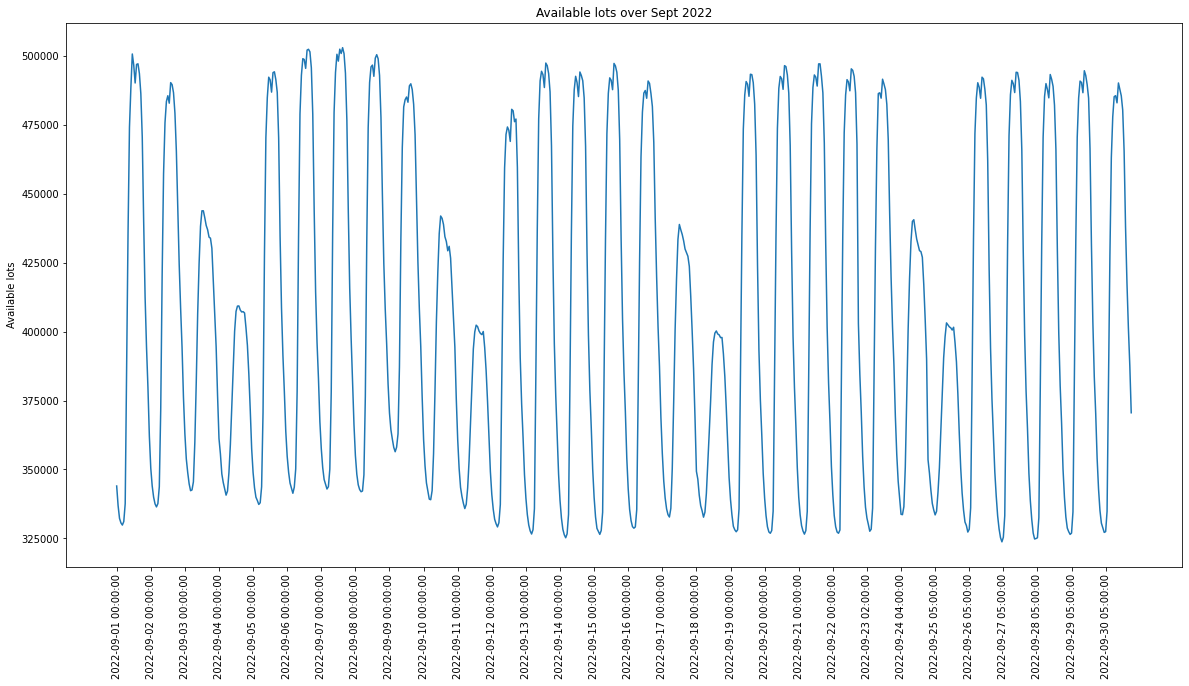

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(agg_df.index, agg_df['lots_available'])
ax.set_xticks(ax.get_xticks()[::24])
plt.xticks(rotation=90)
ax.set_ylabel('Available lots')
ax.set_title('Available lots over Sept 2022')

Text(0.5, 1.0, 'Available lots over a particular day')

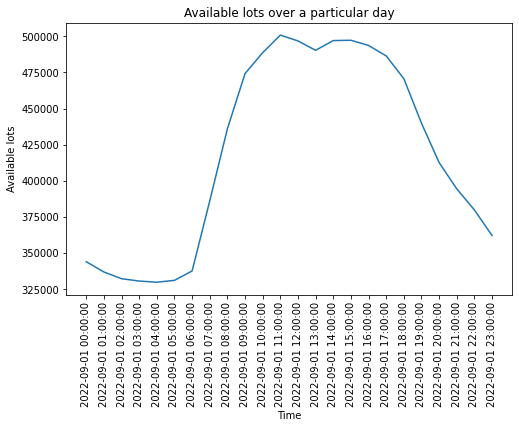

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(agg_df.index[:24], agg_df['lots_available'][:24])
ax.set_xlabel('Time')
plt.xticks(rotation=90)
ax.set_ylabel('Available lots')
ax.set_title('Available lots over a particular day')

As the plot shows, there is a strong periodic pattern over weekdays and weekends within a week. Within each day, there is also a strong periodic patttern over the days and night, whereby the carpark slots are more available at daytime when people goes to work. This corroborates with our intuition.

# Q1.5

In [39]:
df = pd.DataFrame()
for i in range(1,31):
    sub = pd.read_csv(f'{str(i)}.csv')
    df = pd.concat([df, sub])
df['available_percentage'] = df['lots_available']/df['total_lots']

In [41]:
import queue
top5 = queue.PriorityQueue()
unique_keys = set()
ids = df['carpark_number'].unique()
print(len(ids))
for id1 in ids:
    sub1 = df[df['carpark_number'] == id1][['timestamp', 'available_percentage']]
    sub1.drop_duplicates(subset=['timestamp'], inplace=True)
    sub1.index = sub1['timestamp']
    for id2 in ids:
        key = (id1, id2) if id1 < id2 else (id2, id1)
        if id1 == id2 or key in unique_keys:
            continue
        sub2 = df[df['carpark_number'] == id2][['timestamp', 'available_percentage']]
        sub2.drop_duplicates(subset=['timestamp'], inplace=True)
        sub2.index = sub2['timestamp']
        sub2 = sub2.reindex(sub1.index, method='ffill')
        corr = sub1['available_percentage'].corr(sub2['available_percentage'])
        print(f"{id1} and {id2} has correlation {corr}")
        if top5.qsize() < 5:
            top5.put((corr, key))
            unique_keys.add(key)
        elif top5.queue[0][0] < corr:
            removed = top5.get()
            unique_keys.remove(removed[1])
            top5.put((corr, key))
            unique_keys.add(key)

1966
HE12 and HLM has correlation 0.5629171051602865
HE12 and RHM has correlation -0.2067628413243952
HE12 and BM29 has correlation 0.6198043319226764
HE12 and Q81 has correlation 0.6729676089085725
HE12 and C20 has correlation 0.6769003079201421
HE12 and FR3M has correlation 0.5165987948843377
HE12 and C32 has correlation -0.6140709975522447
HE12 and C6 has correlation -0.18412165904343822
HE12 and TG2 has correlation -0.39792050859273465
HE12 and BP1 has correlation -0.5023076591763196
HE12 and TG1 has correlation -0.6155680681187731
HE12 and TGM2 has correlation -0.27371470278457294
HE12 and TE14 has correlation -0.42434247230963773
HE12 and BM3 has correlation -0.5045379704500461
HE12 and BM9 has correlation nan
HE12 and HG44 has correlation 0.6099147756490062
HE12 and HG64 has correlation 0.5722223054785379
HE12 and PM27 has correlation -0.6370898605072856
HE12 and PM28 has correlation -0.5936635002048971
HE12 and TM36 has correlation -0.6311371829776785
HE12 and TM37 has correlat

KeyboardInterrupt: 

(0.6784197904890638, ('HE12', 'J54'))
(0.7072587176212465, ('HE12', 'J46'))
(0.6888122309470982, ('HE12', 'T15'))
(0.7495394958633617, ('HE12', 'KB7'))
(0.7274686841222604, ('HE12', 'KB14'))
